In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gekko import GEKKO

from scipy.signal import savgol_filter

In [2]:
czantoria_full = pd.read_csv('data/csv/czantoria_sauce.csv')
czantoria_full.columns = ['time', 'distance', 'heartrate', 'cadence', 'velocity_smooth', 'altitude', 'grade_smooth']
czantoria_nonzero = czantoria_full[(czantoria_full['velocity_smooth'] > 0) | (czantoria_full['time'] == 0)]
czantoria_time = czantoria_nonzero.groupby('distance').agg({'time': 'max'}).reset_index()['time']
czantoria_final = pd.merge(czantoria_nonzero, czantoria_time, on=['time'])

In [3]:
distance_data = czantoria_final['distance'].to_numpy()
grade_data = czantoria_final['grade_smooth'].to_numpy()
elevation_data = czantoria_final['altitude'].to_numpy()

In [4]:
grade_smooth = savgol_filter(grade_data, 501, 1)

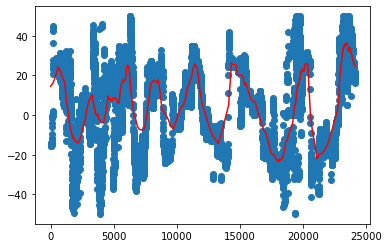

In [5]:
plt.scatter(distance_data, grade_data)
plt.plot(distance_data, grade_smooth, 'r')

In [6]:
grade_data = grade_smooth

print(len(grade_data))

n = distance_data.shape[0]
to_stay = np.zeros(n)
to_stay[0] = 1

for i in range(n - 1):
    if np.abs(grade_data[i+1] - grade_data[i]) < 1.5:
        grade_data[i+1] = grade_data[i]
        to_stay[i+1] = 0
    elif np.sign(grade_data[i+1]) != np.sign(grade_data[i]):
        to_stay[i + 1] = 1
    else:
        to_stay[i + 1] = 1
        
to_stay[-1] = 1

grade_data = grade_data[to_stay == 1]
distance_data = distance_data[to_stay == 1]
elevation_data = elevation_data[to_stay == 1]

print(len(grade_data))

13385
335


In [7]:
# n = grade_smooth.shape[0]
# to_stay = np.zeros(n)
# to_stay[0] = 1

# for i in range(n - 1):
#     if (np.abs(grade_smooth[i+1] - grade_smooth[i]) < 15) and (grade_smooth[i+1] * grade_smooth[i] > 0):
#         grade_smooth[i+1] = grade_smooth[i]

In [8]:
grade_data = np.arctan(grade_data/100)

In [9]:
distance = distance_data[-1]

x_data = distance_data/(distance_data[-1])
slope_data = grade_data

In [10]:
# create GEKKO model
m = GEKKO()

In [11]:
t_min = 1 * 60 * 60
t_est = 4 * 60 * 60
t_max = 8 * 60 * 60

In [12]:
# constants
N_m = 0.0222
E0 = 1400
X = distance
tau = 0.67
g = 9.81
k = 0.03734
mass = 55
S = 22

In [13]:
# equation parts
alpha = (np.sqrt(S/tau) * X)/E0
gamma = X/np.sqrt(S * tau**3)
delta = (g*X)/(S*tau)

In [14]:
# scales
u_scale = np.sqrt(S/tau)
v_scale = np.sqrt(S*tau)
t_scale = X/v_scale

In [15]:
# scaled values
sigma0 = 1
e0 = 1
x0 = 0
v0 = 0

e_crit = 0.15 * e0

In [16]:
# slope data to create spline
# x_data = np.linspace(0, 1, 10)
# slope_data = np.array(1*[1/18 * np.pi] + 1 * [-1/18 * np.pi] + 1 *[1/36 * np.pi] + 1 * [-1/36 * np.pi] + 1 * [1/9 * np.pi] + 1*[1/18 * np.pi] + 1 * [-1/18 * np.pi] + 1*[1/36 * np.pi] + 1 * [-1/36 * np.pi] + 1 * [1/9 * np.pi])

In [17]:
# time points [s]
nt = 201
tm = np.linspace(0,1,nt)
m.time = tm

In [18]:
# Variables
v = m.Var(value=0.0, lb=0.0, ub=6/v_scale) #velocity
E = m.Var(value=e0, lb=0.0, ub=e0) #energy
x = m.Var(value=0.0) #horizontal coordinate
sigma = m.Const(value=1.0)
slope = m.Var(value=slope_data[0]) #slope

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

In [19]:
tf = m.FV(value=t_est/t_scale, lb = t_min/t_scale, ub=t_max/t_scale)
tf.STATUS = 1

In [20]:
# MV
u = m.MV(value=0,lb=0,ub=9.6/u_scale)
u.STATUS = 1

In [21]:
# slope
m.cspline(x, slope, x_data, slope_data, True)

In [22]:
# equations
m.Equation(E.dt()==(alpha * (sigma - u * v))*tf)
m.Equation(v.dt()==(gamma * (u - v) - delta * m.sin(slope)) * tf)
m.Equation(x.dt()==(v*m.cos(slope))*tf)
m.Equation((distance - X*x)*final<=0)
m.Equation(sigma - u * v <= 0)

m.fix_final(E, 0)

In [23]:
m.options.IMODE = 6
m.options.MAX_ITER=15000
m.options.SOLVER=3
# m.options.RTOL=1e-4
# m.options.OTOL=1e-4

m.solve()

print('Final Time: ' + str(tf.value[0] * t_scale))

tm = tm * tf.value[0] * t_scale

apm 80.253.213.10_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            1
   Constants    :            1
   Variables    :            9
   Intermediates:            0
   Connections  :            4
   Equations    :            5
   Residuals    :            5
 
 Number of state variables:           2799
 Number of total equations: -         2600
 Number of slack variables: -          400
 ---------------------------------------
 Degrees of freedom       :           -201
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This 

  97r 1.8016899e-02 2.35e+04 1.00e+03  -5.8 7.94e-02   4.1 1.00e+00 8.65e-03f  1
  98r 1.8016907e-02 2.35e+04 1.21e+03  -4.6 2.59e-01   3.7 1.00e+00 1.23e-02f  1
  99r 1.8017268e-02 2.35e+04 1.17e+03  -2.2 7.37e-01   3.2 1.00e+00 9.20e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100r 1.8032755e-02 2.34e+04 1.19e+03   0.6 2.22e+00   2.7 1.85e-01 1.72e-02f  1
 101r 1.8062463e-02 2.34e+04 2.38e+03   1.0 8.55e-01   3.1 3.18e-02 3.54e-02f  1
 102r 1.8191312e-02 2.34e+04 2.21e+03   0.8 2.37e+00   2.7 2.04e-01 8.41e-02f  1
 103r 1.8205044e-02 2.34e+04 2.17e+03   0.8 8.71e-01   3.1 1.71e-01 2.49e-02f  1
 104r 1.8206697e-02 2.34e+04 3.40e+03   0.0 4.23e-02   4.4 1.00e+00 3.99e-01f  1
 105r 1.8242014e-02 2.34e+04 4.64e+03   0.7 1.23e-01   3.9 7.67e-01 6.02e-01f  1
 106r 1.8245964e-02 2.34e+04 8.47e+03   0.8 7.38e-03   5.3 1.00e+00 1.00e+00f  1
 107r 1.8246683e-02 2.34e+04 8.33e+03   0.5 3.72e-03   5.7 9.99e-01 1.00e+00f  1
 108r 1.8246942e-02 2.34e+04

 234r 1.8622779e-02 2.33e+04 1.12e+03  -7.0 3.54e-04   6.5 1.00e+00 1.82e-01f  1
 235r 1.8622779e-02 2.33e+04 1.12e+03  -7.1 1.06e-03   6.0 1.00e+00 2.30e-01f  1
 236r 1.8622779e-02 2.33e+04 1.12e+03  -7.2 3.99e-04   6.4 1.00e+00 1.17e-01f  1
 237r 1.8622779e-02 2.33e+04 1.12e+03  -6.4 1.20e-03   6.0 1.00e+00 1.49e-01f  1
 238r 1.8622779e-02 2.33e+04 1.12e+03  -6.4 4.48e-04   6.4 1.00e+00 1.37e-01f  1
 239r 1.8622779e-02 2.33e+04 1.12e+03  -6.8 1.34e-03   5.9 1.00e+00 7.30e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r 1.8622779e-02 2.33e+04 1.12e+03  -5.7 5.04e-04   6.3 1.00e+00 2.48e-01f  1
 241r 1.8622779e-02 2.33e+04 1.12e+03  -6.0 1.51e-03   5.9 1.00e+00 1.23e-01f  1
 242r 1.8622779e-02 2.33e+04 1.12e+03  -4.0 4.53e-03   5.4 1.58e-01 1.25e-02f  1
 243r 1.8622779e-02 2.33e+04 1.12e+03  -5.1 1.70e-03   5.8 1.00e+00 5.88e-02f  1
 244r 1.8622779e-02 2.33e+04 1.18e+03  -5.5 5.09e-03   5.3 1.00e+00 8.61e-02f  1
 245r 1.8622779e-02 2.33e+04

 327r 1.8666660e-02 2.29e+04 1.06e+03  -2.0 3.54e-03   5.5 1.00e+00 1.00e+00f  1
 328r 1.8666659e-02 2.29e+04 1.06e+03  -2.9 1.33e-03   5.9 1.00e+00 7.65e-01f  1
 329r 1.8666659e-02 2.29e+04 1.06e+03  -3.2 4.99e-04   6.3 1.00e+00 7.15e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 330r 1.8666659e-02 2.29e+04 1.07e+03  -3.7 1.87e-04   6.8 1.00e+00 8.27e-01f  1
 331r 1.8666659e-02 2.29e+04 1.07e+03  -4.1 5.63e-04   6.3 1.00e+00 5.81e-01f  1
 332r 1.8666659e-02 2.29e+04 1.07e+03  -4.8 2.11e-04   6.7 1.00e+00 5.53e-01f  1
 333r 1.8666659e-02 2.29e+04 1.07e+03  -5.3 6.33e-04   6.2 1.00e+00 2.85e-01f  1
 334r 1.8666659e-02 2.29e+04 1.07e+03  -4.7 2.37e-04   6.7 1.00e+00 6.22e-01f  1
 335r 1.8666659e-02 2.29e+04 1.07e+03  -5.1 7.12e-04   6.2 1.00e+00 1.24e-01f  1
 336r 1.8666659e-02 2.29e+04 1.07e+03  -6.5 2.67e-04   6.6 1.00e+00 3.27e-01f  1
 337r 1.8666659e-02 2.29e+04 1.07e+03  -7.0 8.01e-04   6.1 1.00e+00 6.55e-02f  1
 338r 1.8666659e-02 2.29e+04

 464r 2.1153673e-02 2.16e+04 1.00e+03  -5.7 2.58e-03   5.6 1.00e+00 2.90e-02f  1
 465r 2.1153673e-02 2.16e+04 1.01e+03  -6.0 7.73e-03   5.1 1.00e+00 1.13e-01f  1
 466r 2.1153673e-02 2.16e+04 1.01e+03  -5.8 2.58e-02   4.7 1.00e+00 3.29e-02f  1
 467r 2.1153673e-02 2.16e+04 1.01e+03  -5.1 8.91e-02   4.2 1.00e+00 2.66e-02f  1
 468r 2.1153673e-02 2.16e+04 1.01e+03  -4.2 2.40e-01   3.7 1.00e+00 1.02e-02f  1
 469r 2.1153680e-02 2.16e+04 1.18e+03  -1.8 9.67e-02   4.1 1.00e+00 3.52e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470r 2.1154210e-02 2.16e+04 1.04e+03   0.1 2.87e-01   3.7 1.00e+00 2.33e-02f  1
 471r 2.1164264e-02 2.16e+04 1.00e+03   0.3 6.81e-01   3.2 4.24e-01 7.80e-02f  1
 472r 2.1164554e-02 2.16e+04 3.14e+03  -0.4 3.21e-02   4.5 8.97e-01 3.27e-01f  1
 473r 2.1164569e-02 2.16e+04 2.70e+03  -0.7 1.80e-02   4.9 1.00e+00 9.65e-02f  1
 474r 2.1164667e-02 2.16e+04 1.78e+03  -0.9 3.62e-02   4.5 1.00e+00 3.71e-01f  1
 475r 2.1164842e-02 2.16e+04

 558r 2.6889160e-02 1.77e+04 1.14e+03   0.4 1.79e-01   3.8 4.17e-01 2.78e-01f  1
 559r 2.6889184e-02 1.77e+04 1.05e+03  -0.6 8.36e-03   5.1 1.00e+00 2.08e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 560r 2.6889512e-02 1.77e+04 1.06e+03  -0.5 2.52e-02   4.6 1.00e+00 6.69e-01f  1
 561r 2.6889780e-02 1.77e+04 1.07e+03  -0.7 7.57e-02   4.2 6.77e-01 3.21e-01f  1
 562r 2.6890630e-02 1.77e+04 1.34e+03  -0.1 2.27e-01   3.7 8.80e-01 6.41e-02f  1
 563r 2.6899735e-02 1.77e+04 1.95e+03   0.3 7.14e-01   3.2 2.81e-01 1.02e-01f  1
 564r 2.7021157e-02 1.76e+04 2.82e+03   1.0 2.31e+00   2.7 1.50e-01 9.52e-02f  1
 565r 2.7025320e-02 1.76e+04 2.18e+03   0.5 9.77e-02   4.1 1.00e+00 2.09e-01f  1
 566r 2.7036172e-02 1.76e+04 1.49e+03   0.2 2.88e-01   3.6 8.55e-01 4.10e-01f  1
 567r 2.7036173e-02 1.76e+04 2.19e+03  -1.3 1.62e-03   5.8 1.00e+00 7.58e-01f  1
 568r 2.7036290e-02 1.76e+04 4.25e+03  -0.2 6.16e-03   5.3 1.00e+00 5.73e-01f  1
 569r 2.7036308e-02 1.76e+04

 657r 3.3700354e-02 1.40e+04 1.48e+07   2.6 4.91e-02   8.3 1.00e+00 5.00e-01h  1
 658r 3.3700354e-02 1.40e+04 1.30e+08   2.6 2.57e-01   9.6 5.77e-02 8.70e-02h  1
 659r 3.3700354e-02 1.40e+04 1.29e+08   2.6 6.01e-02   9.1 5.29e-01 2.46e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 660r 3.3700355e-02 1.40e+04 5.49e+07   2.6 6.96e-02   9.6 2.30e-01 1.53e-01h  1
 661r 3.3700363e-02 1.40e+04 3.85e+08   2.6 6.67e-02   9.1 1.00e+00 4.40e-01h  1
 662r 3.3700363e-02 1.40e+04 3.83e+08   2.6 1.19e-01   8.6 9.88e-01 4.92e-03h  1
 663r 3.3700367e-02 1.40e+04 3.16e+08   2.6 9.62e-02   9.0 1.00e+00 1.91e-01h  1
 664r 3.3700370e-02 1.40e+04 2.98e+08   2.6 1.47e-01   8.6 9.78e-01 5.75e-02h  1
 665r 3.3700375e-02 1.40e+04 4.32e+08   2.6 1.38e-01   9.0 1.00e+00 2.05e-01h  1
 666r 3.3700399e-02 1.40e+04 2.92e+08   2.6 1.11e-01   8.5 1.00e+00 3.58e-01h  1
 667r 3.3700404e-02 1.40e+04 2.36e+08   2.6 7.13e-02   8.9 1.00e+00 1.97e-01h  1
 668r 3.3700434e-02 1.40e+04

 767  4.0796219e-02 1.12e+04 1.81e+04  -0.1 1.45e+04    -  1.05e-02 1.03e-02h  1
 768  4.0966213e-02 1.12e+04 3.89e+04  -0.1 1.46e+04    -  1.28e-02 4.77e-03h  1
 769  4.1014375e-02 1.11e+04 3.76e+04  -0.1 1.48e+04    -  5.01e-03 1.33e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770  4.1042086e-02 1.11e+04 4.63e+05  -0.1 1.49e+04    -  2.00e-02 7.53e-04h  1
 771  4.1081601e-02 1.11e+04 3.12e+05  -0.1 1.50e+04    -  6.94e-04 1.06e-03h  1
 772  4.1089043e-02 1.11e+04 2.25e+05  -0.1 2.36e+04    -  4.74e-05 1.53e-04h  1
 773  4.1088607e-02 1.11e+04 3.62e+05  -0.1 4.25e+05    -  3.98e-06 4.64e-06h  1
 774  4.1088483e-02 1.11e+04 3.62e+05  -0.1 1.70e+06    -  2.87e-07 2.87e-07s  2
 775r 4.1088483e-02 1.11e+04 1.00e+03   1.7 0.00e+00    -  0.00e+00 0.00e+00R  1
 776r 5.0324282e-02 9.43e+03 3.55e+03   2.4 2.36e+03    -  1.59e-02 3.00e-03f  1
 777  5.0328993e-02 9.42e+03 6.62e+01  -0.1 4.21e+03    -  9.13e-03 1.52e-04f  1
 778  5.0331424e-02 9.42e+03

 862  6.1810361e-02 1.13e+03 2.54e+04  -0.8 2.52e+03    -  8.07e-03 2.72e-04h  1
 863  6.1898568e-02 1.11e+03 2.97e+04  -0.8 3.17e+03    -  1.44e-02 1.15e-02h  1
 864  6.1951837e-02 1.11e+03 3.61e+04  -0.8 5.11e+03    -  1.43e-04 6.62e-03f  1
 865  6.1953548e-02 1.11e+03 3.61e+04  -0.8 1.97e+04    -  5.76e-04 2.50e-04f  1
 866  6.1953683e-02 1.11e+03 3.61e+04  -0.8 1.51e+04    -  6.29e-05 1.65e-05h  1
 867  6.1962973e-02 1.10e+03 2.49e+04  -0.8 6.99e+03    -  1.17e-03 1.13e-03h  1
 868  6.1979925e-02 1.10e+03 2.49e+04  -0.8 3.84e+03    -  7.38e-04 2.03e-03h  1
 869  6.1989734e-02 1.10e+03 2.49e+04  -0.8 5.57e+03    -  7.77e-04 1.16e-03h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 870r 6.1989734e-02 1.10e+03 9.99e+02   1.2 0.00e+00  17.3 0.00e+00 4.77e-07R 22
 871r 6.2325685e-02 8.28e+02 9.97e+02   0.9 5.62e+03    -  1.25e-03 2.45e-03f  1
 872  6.2396844e-02 8.17e+02 1.62e+01  -0.8 1.67e+03    -  2.70e-03 1.26e-02f  1
 873  6.2698632e-02 7.94e+02

 977r 7.5360911e-02 5.66e-01 5.15e+04  -2.1 5.07e-02   4.3 5.34e-01 1.37e-01f  1
 978r 7.5362122e-02 6.37e-01 4.83e+04   0.6 3.22e-01   3.8 6.29e-02 7.62e-02f  1
 979r 7.5363010e-02 6.14e-01 4.08e+04  -0.1 2.47e-01   3.3 3.00e-01 1.01e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 980r 7.5366095e-02 5.90e-01 3.65e+04  -0.1 1.43e-01   2.8 8.72e-02 1.12e-01f  1
 981r 7.5366215e-02 4.85e-01 9.12e+03  -0.1 5.33e-03   5.1 7.56e-01 7.46e-01f  1
 982r 7.5366257e-02 4.85e-01 8.60e+03  -0.1 7.71e-03   5.5 1.00e+00 6.78e-01f  1
 983r 7.5366436e-02 4.86e-01 3.85e+03  -0.1 9.03e-03   5.0 1.00e+00 9.74e-01f  1
 984r 7.5366457e-02 4.87e-01 3.12e+03  -0.4 7.14e-03   5.4 1.00e+00 6.07e-01f  1
 985r 7.5366459e-02 4.87e-01 7.67e+03  -0.8 2.05e-03   5.9 1.00e+00 5.87e-01f  1
 986r 7.5366503e-02 4.87e-01 5.31e+03  -0.4 3.22e-03   5.4 1.00e+00 1.00e+00f  1
 987r 7.5366513e-02 4.87e-01 7.09e+03  -0.5 3.29e-03   5.8 1.00e+00 8.18e-01f  1
 988r 7.5366516e-02 4.87e-01

1074  1.6697029e-01 8.32e+01 4.22e+02  -0.9 7.60e+02    -  3.09e-01 2.16e-02h  4
1075  1.6885052e-01 8.09e+01 5.37e+02  -0.9 8.87e+02    -  3.39e-01 2.83e-02h  3
1076  1.7109859e-01 7.91e+01 7.06e+02  -0.9 9.54e+02    -  1.19e-01 2.26e-02h  3
1077  1.8605580e-01 2.96e+02 4.91e+02  -0.9 7.71e+02    -  9.26e-02 1.34e-01w  1
1078  2.0344792e-01 5.90e+02 7.20e+02  -0.9 6.15e+02    -  4.56e-02 1.42e-01w  1
1079  2.1955918e-01 5.25e+02 1.12e+03  -0.9 6.05e+02    -  3.23e-02 1.25e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1080  1.7483789e-01 7.63e+01 8.55e+02  -0.9 5.97e+02    -  9.26e-02 3.35e-02h  2
1081  1.7942573e-01 7.34e+01 8.90e+02  -0.9 8.12e+02    -  1.20e-01 3.74e-02h  2
1082  1.8530613e-01 1.10e+02 8.37e+02  -0.9 7.09e+02    -  9.27e-02 4.22e-02f  3
1083  1.9211491e-01 1.06e+02 1.05e+03  -0.9 8.17e+02    -  1.59e-01 4.41e-02f  2
1084  2.4348751e-01 5.77e+02 6.25e+02  -0.9 5.40e+02    -  1.03e-01 2.80e-01f  1
1085  2.7232792e-01 6.07e+02

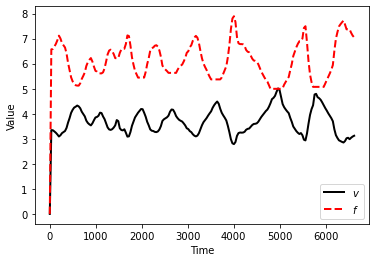

In [24]:
plt.figure(1)
plt.plot(tm,np.array(v.value) * v_scale,'k-',lw=2,label=r'$v$')
plt.plot(tm,np.array(u.value) * u_scale,'r--',lw=2,label=r'$f$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

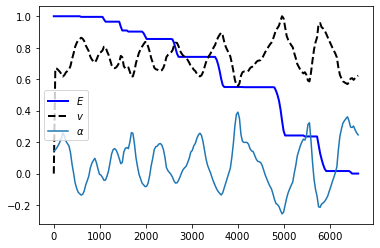

In [25]:
plt.figure(2)
plt.plot(tm,np.array(E.value)/max(E.value),'b-',lw=2,label=r'$E$')
plt.plot(tm,np.array(v.value)/max(v.value),'k--',lw=2,label=r'$v$')
plt.plot(tm,slope, label=r'$\alpha$')
plt.legend()
plt.show()

In [26]:
5496.557240864244
5470.811627159549

5470.811627159549